# **Multi-dimensional Adapted Wasserstein Distance (Non-Markovian Case)**

This notebook presents how to compute the adapted Wasserstein distance in a multi-dimensional setting for the non-Markovian case. Specifically, we consider a 2D spatial dimension (`d = 2`) and a 2D time dimension (`T = 2`), resulting in a total dimension of `4`. 


In [ ]:
import os, sys, numpy as np, time, random, warnings
import matplotlib.pyplot as plt

# Set up the source path
notebooks_path = os.path.abspath(os.getcwd())
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

from benchmark_value_gaussian.Comp_AWD2_Gaussian import *

# Solver and measure generation module
from optimal_code.utils_multidim import *
from optimal_code.optimal_solver_multidim import *

### Defining Parameters

In [2]:
sample_sizes = [4000, 6000, 10000, 15000, 20000, 25000, 35000, 50000, 75000]
fixed_grid = 0.4
n_runs = 10

# Define matrices (dimension 4)
L = np.array([[1, 0, 0, 0],
              [1, 2, 0, 0],
              [1, 2, 3, 0],
              [1, 2, 3, 4]])
M = np.array([[1, 0, 0, 0],
              [2, 1, 0, 0],
              [3, 2, 1, 0],
              [4, 3, 2, 1]])

# Parameters
d = 2
T = 2
dim = d * T

a, b = np.zeros(dim), np.zeros(dim)

### Running experiments with the grid

Could have been done with the k-means, however, k-means takes too much time to generate the adapted measure.

In [3]:
results = {}  # Dictionary to store results keyed by sample size

for n_sample in sample_sizes:
    distances_runs = np.zeros(n_runs)
    times_runs = np.zeros(n_runs)
    
    print(f"\nRunning experiments for sample size: {n_sample}")
    
    for run in range(n_runs):
        seed = np.random.randint(10000)
        
        # Generate sample paths:
        X, A = Lmatrix2paths_flat(L, n_sample, d, T, seed=seed, verbose=False)
        Y, B = Lmatrix2paths_flat(M, n_sample, d, T, seed=seed, verbose=False)
        
        # Compute the theoretical benchmark distance
        benchmark = adapted_wasserstein_squared_multidim(a, A, b, B, d, T)



        #--------------------------------------------------
        # PROCEDURE: Computing AW_2^2 in Non-Markovian Multi-Dimensional Setting
        #---------------------------------------------------
        
        # Convert paths to adapted versions using the fixed grid
        adaptedX = path2adaptedpath_multidim(X, delta_n=fixed_grid)
        adaptedY = path2adaptedpath_multidim(Y, delta_n=fixed_grid)
        
        # Build quantization mapping:
        # Reshape the data so that we obtain a list of all ℝ² points:
        # adaptedX: shape (T+1, n_sample, d) -> (n_sample, T+1, d)
        points_X = adaptedX.transpose(1,0,2).reshape(-1, d)
        points_Y = adaptedY.transpose(1,0,2).reshape(-1, d)
        # Use np.unique along axis=0 to get unique grid points in ℝ².
        q2v = np.unique(np.concatenate([points_X, points_Y], axis=0), axis=0)
        # Convert each unique row (a 2D vector) to a tuple so it can be used as a key.
        q2v_list = [tuple(row) for row in q2v]
        v2q = {val: i for i, val in enumerate(q2v_list)}
        
        # Quantize each path: iterate over sample paths.
        # Resulting qX will have shape (n_sample, T+1) with integer entries.
        qX = np.array([[v2q[tuple(x)] for x in sample] 
                        for sample in adaptedX.transpose(1,0,2)])
        qY = np.array([[v2q[tuple(x)] for x in sample] 
                        for sample in adaptedY.transpose(1,0,2)])
        
        # Sort the quantized paths lexicographically (as in your 1D code)
        qX = sort_qpath_multidim(qX.T)
        qY = sort_qpath_multidim(qY.T)
        
        # Build conditional distributions from the quantized paths.
        mu_x = qpath2mu_x_multidim(qX)
        nu_y = qpath2mu_x_multidim(qY)
        mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn = list_repr_mu_x_multidim(mu_x, q2v)
        nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn = list_repr_mu_x_multidim(nu_y, q2v)
        
        # Compute the numerical adapted Wasserstein squared distance.
        t_start = time.perf_counter()
        AW_2square = nested2_parallel_multidim(mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn,
                                        nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn,
                                        n_processes=42, power=2)
        elapsed = time.perf_counter() - t_start


        #--------------------------------------------------
        # END OF PROCEDURE
        #---------------------------------------------------
        
        distances_runs[run] = AW_2square
        times_runs[run] = elapsed
        
        print(f"Sample size {n_sample}, Run {run+1}: AW_2^2 = {AW_2square:.4f}, Time = {elapsed:.4f} s")
    
    # Store the results for the current sample size
    results[n_sample] = {"distances": distances_runs,
                         "times": times_runs,
                         "benchmark": benchmark}


Running experiments for sample size: 4000


  0%|                                                     | 0/8 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 146.29it/s]


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 74.85it/s]

 78%|███████████████████████████████████          | 7/9 [00:00<00:00, 69.66it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 63.78it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 75.99it/s]


Sample size 4000, Run 1: AW_2^2 = 21.0787, Time = 0.6543 s


100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 151.96it/s]


  0%|                                                     | 0/8 [00:00<?, ?it/s]

 44%|████████████████████                         | 4/9 [00:00<00:00, 34.50it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 63.40it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 47.48it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 49.09it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 94.45it/s]


Sample size 4000, Run 2: AW_2^2 = 21.7953, Time = 0.5749 s


100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 145.95it/s]

  0%|                                                     | 0/8 [00:00<?, ?it/s]


100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 187.28it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 71.92it/s]

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 129.86it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 78.05it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 44.88it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 108.70it/s]


Sample size 4000, Run 3: AW_2^2 = 21.4193, Time = 0.5880 s


  0%|                                                     | 0/8 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 139.80it/s]

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 315.52it/s]



100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 65.26it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 60.38it/s]


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 67.67it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 45.78it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 100.55it/s]


Sample size 4000, Run 4: AW_2^2 = 20.5477, Time = 0.5790 s


  0%|                                                     | 0/9 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 117.93it/s]

  0%|                                                     | 0/8 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 279.40it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 81.40it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 46.74it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 101.03it/s]


Sample size 4000, Run 5: AW_2^2 = 22.7589, Time = 0.6280 s


100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 105.37it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 105.53it/s]

 50%|██████████████████████▌                      | 4/8 [00:00<00:00, 37.65it/s]

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 244.86it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 103.06it/s]


Sample size 4000, Run 6: AW_2^2 = 22.0203, Time = 0.6032 s


100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 162.28it/s]

  0%|                                                     | 0/9 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 74.59it/s]

  0%|                                                     | 0/8 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 87.83it/s]


 56%|█████████████████████████                    | 5/9 [00:00<00:00, 41.35it/s]


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 81.46it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 97.85it/s]


Sample size 4000, Run 7: AW_2^2 = 22.2393, Time = 0.6223 s


100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 427.34it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 189.85it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 112.62it/s]

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 151.28it/s]


100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 217.69it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 91.29it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 99.91it/s]


Sample size 4000, Run 8: AW_2^2 = 21.6375, Time = 0.6017 s


100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 144.27it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 107.97it/s]

  0%|                                                     | 0/8 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 81.20it/s]



100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 99.89it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 38.33it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 108.36it/s]


Sample size 4000, Run 9: AW_2^2 = 21.3466, Time = 0.6218 s


  0%|                                                     | 0/8 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 165.71it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 82.41it/s]

 75%|█████████████████████████████████▊           | 6/8 [00:00<00:00, 59.69it/s]

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 149.18it/s]

 75%|█████████████████████████████████▊           | 6/8 [00:00<00:00, 57.01it/s]




100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 145.23it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 57.94it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 36.69it/s]

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 100.53it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 110.15it/s]


Sample size 4000, Run 10: AW_2^2 = 21.1153, Time = 0.6543 s

Running experiments for sample size: 6000


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 136.82it/s]

  0%|                                                     | 0/9 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 75.48it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 56.47it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 38.16it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 92.18it/s]


Sample size 6000, Run 1: AW_2^2 = 22.6892, Time = 0.8288 s


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 160.88it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 70.18it/s]



100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 55.13it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 36.36it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 91.73it/s]


Sample size 6000, Run 2: AW_2^2 = 21.9646, Time = 0.8518 s


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 71.34it/s]

 44%|████████████████████                         | 4/9 [00:00<00:00, 37.20it/s]

 56%|█████████████████████████                    | 5/9 [00:00<00:00, 44.53it/s]

 33%|███████████████                              | 3/9 [00:00<00:00, 21.95it/s]

 78%|███████████████████████████████████          | 7/9 [00:00<00:00, 65.67it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 45.02it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 94.60it/s]


Sample size 6000, Run 3: AW_2^2 = 21.7146, Time = 0.7449 s


100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 114.04it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 73.12it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 92.67it/s]


Sample size 6000, Run 4: AW_2^2 = 21.7901, Time = 0.7882 s


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 43.55it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 93.04it/s]


Sample size 6000, Run 5: AW_2^2 = 22.5166, Time = 0.8235 s


  0%|                                                     | 0/9 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 102.22it/s]


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 64.15it/s]

 67%|██████████████████████████████               | 6/9 [00:00<00:00, 52.23it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 63.93it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 82.69it/s]


Sample size 6000, Run 6: AW_2^2 = 22.2176, Time = 0.8013 s


  0%|                                                     | 0/9 [00:00<?, ?it/s]

  0%|                                                     | 0/9 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 57.36it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 126.78it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 73.08it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 98.31it/s]


Sample size 6000, Run 7: AW_2^2 = 22.2577, Time = 0.7910 s


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 123.98it/s]


 78%|███████████████████████████████████          | 7/9 [00:00<00:00, 69.13it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 125.56it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 68.14it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 95.56it/s]


Sample size 6000, Run 8: AW_2^2 = 22.0531, Time = 0.7767 s


100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 172.36it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 88.39it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 51.04it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 31.16it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 96.01it/s]


Sample size 6000, Run 9: AW_2^2 = 22.4835, Time = 0.8153 s


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 126.66it/s]

  0%|                                                     | 0/9 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 220.50it/s]



100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 79.33it/s]

 67%|██████████████████████████████               | 6/9 [00:00<00:00, 56.59it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 96.03it/s]


Sample size 6000, Run 10: AW_2^2 = 21.5749, Time = 0.8002 s

Running experiments for sample size: 10000


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 80.02it/s]

 20%|████████▊                                   | 2/10 [00:00<00:00, 10.02it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 56.84it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 75.04it/s]


Sample size 10000, Run 1: AW_2^2 = 22.2027, Time = 1.2964 s


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 71.42it/s]


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 111.33it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 70.77it/s]


Sample size 10000, Run 2: AW_2^2 = 22.2616, Time = 1.3640 s


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 101.32it/s]

 60%|██████████████████████████▍                 | 6/10 [00:00<00:00, 28.80it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 48.41it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 76.66it/s]


Sample size 10000, Run 3: AW_2^2 = 22.6856, Time = 1.2610 s


  0%|                                                    | 0/11 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 71.28it/s]


Sample size 10000, Run 4: AW_2^2 = 21.9101, Time = 1.2626 s


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 110.40it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 38.92it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 77.82it/s]


Sample size 10000, Run 5: AW_2^2 = 21.8101, Time = 1.3473 s


  0%|                                                    | 0/10 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 62.37it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 75.58it/s]


Sample size 10000, Run 6: AW_2^2 = 22.2965, Time = 1.2970 s


 10%|████▍                                       | 1/10 [00:00<00:01,  8.99it/s]


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 74.31it/s]

 20%|████████▊                                   | 2/10 [00:00<00:00, 19.71it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 70.30it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 41.46it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 43.89it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 71.47it/s]


Sample size 10000, Run 7: AW_2^2 = 22.1489, Time = 1.3119 s


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 354.16it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 85.74it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 23.46it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 78.01it/s]


Sample size 10000, Run 8: AW_2^2 = 22.0998, Time = 1.3250 s


 91%|███████████████████████████████████████    | 10/11 [00:00<00:00, 97.00it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 93.62it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 72.08it/s]


Sample size 10000, Run 9: AW_2^2 = 22.5766, Time = 1.2105 s


 70%|██████████████████████████████▊             | 7/10 [00:00<00:00, 62.59it/s]

 90%|███████████████████████████████████████▌    | 9/10 [00:00<00:00, 79.75it/s]

 10%|████▍                                       | 1/10 [00:00<00:01,  7.82it/s]

 10%|████▍                                       | 1/10 [00:00<00:01,  8.02it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 51.50it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 77.01it/s]


Sample size 10000, Run 10: AW_2^2 = 22.1504, Time = 1.2362 s

Running experiments for sample size: 15000


 36%|████████████████                            | 4/11 [00:00<00:00, 37.93it/s]

 55%|████████████████████████                    | 6/11 [00:00<00:00, 48.63it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 37.82it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 65.09it/s]


Sample size 15000, Run 1: AW_2^2 = 22.3541, Time = 2.2743 s


 36%|████████████████                            | 4/11 [00:00<00:00, 32.03it/s]


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 83.02it/s]


 18%|████████                                    | 2/11 [00:00<00:00,  9.14it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 54.83it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 63.96it/s]


Sample size 15000, Run 2: AW_2^2 = 22.5882, Time = 2.2085 s


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 37.70it/s]

100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.49it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 42.68it/s]


Sample size 15000, Run 3: AW_2^2 = 23.0646, Time = 2.0882 s


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 72.46it/s]

 55%|████████████████████████                    | 6/11 [00:00<00:00, 28.44it/s]


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 88.40it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 68.09it/s]


Sample size 15000, Run 4: AW_2^2 = 22.0802, Time = 2.1462 s


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 29.33it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 65.83it/s]


Sample size 15000, Run 5: AW_2^2 = 22.1014, Time = 2.3448 s


  0%|                                                    | 0/11 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 47.93it/s]

 27%|████████████                                | 3/11 [00:00<00:00, 29.11it/s]


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 64.38it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 61.97it/s]


Sample size 15000, Run 6: AW_2^2 = 21.8753, Time = 1.9380 s


  0%|                                                    | 0/11 [00:00<?, ?it/s]

 55%|████████████████████████                    | 6/11 [00:00<00:00, 57.68it/s]

 80%|███████████████████████████████████▏        | 8/10 [00:00<00:00, 71.97it/s]

 18%|████████                                    | 2/11 [00:00<00:01,  6.34it/s]

 45%|████████████████████                        | 5/11 [00:00<00:00,  7.34it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 69.50it/s]


Sample size 15000, Run 7: AW_2^2 = 22.0164, Time = 2.4035 s


  0%|                                                    | 0/10 [00:00<?, ?it/s]

 18%|████████                                    | 2/11 [00:00<00:00, 10.27it/s]

 50%|██████████████████████                      | 5/10 [00:00<00:00, 45.35it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 69.32it/s]


Sample size 15000, Run 8: AW_2^2 = 22.3501, Time = 2.1826 s


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 65.73it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 70.82it/s]


Sample size 15000, Run 9: AW_2^2 = 21.7639, Time = 2.0073 s


 27%|████████████                                | 3/11 [00:00<00:00, 28.58it/s]


 18%|████████                                    | 2/11 [00:00<00:00, 15.83it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 25.87it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 63.81it/s]


Sample size 15000, Run 10: AW_2^2 = 22.2597, Time = 2.2056 s

Running experiments for sample size: 20000


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 38.51it/s]

100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.48it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 61.74it/s]


Sample size 20000, Run 1: AW_2^2 = 22.0895, Time = 2.7299 s


  8%|███▋                                        | 1/12 [00:00<00:01,  6.55it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 70.05it/s]

  8%|███▋                                        | 1/12 [00:00<00:02,  3.82it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 63.81it/s]


Sample size 20000, Run 2: AW_2^2 = 22.0835, Time = 3.1514 s


 18%|████████                                    | 2/11 [00:00<00:00, 10.20it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 14.60it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 59.08it/s]


Sample size 20000, Run 3: AW_2^2 = 22.2720, Time = 3.2040 s


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 72.20it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 63.50it/s]


Sample size 20000, Run 4: AW_2^2 = 21.8449, Time = 2.9772 s


 42%|██████████████████▎                         | 5/12 [00:00<00:00, 40.23it/s]


 18%|████████                                    | 2/11 [00:00<00:00, 15.10it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 30.61it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 23.16it/s]

 75%|█████████████████████████████████           | 9/12 [00:01<00:00, 13.02it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 60.12it/s]


Sample size 20000, Run 5: AW_2^2 = 22.1613, Time = 3.2109 s


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 39.51it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 61.70it/s]


Sample size 20000, Run 6: AW_2^2 = 22.0864, Time = 2.6653 s


  0%|                                                    | 0/11 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 56.18it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 36.56it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 55.79it/s]


Sample size 20000, Run 7: AW_2^2 = 22.0336, Time = 3.3996 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 60.39it/s]


Sample size 20000, Run 8: AW_2^2 = 21.9821, Time = 3.2764 s


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 50.97it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 81.98it/s]

 17%|███████▎                                    | 2/12 [00:00<00:01,  6.56it/s]

 17%|███████▎                                    | 2/12 [00:00<00:01,  6.89it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 45.87it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 57.62it/s]


Sample size 20000, Run 9: AW_2^2 = 21.9643, Time = 3.2664 s


 75%|█████████████████████████████████           | 9/12 [00:00<00:00, 42.46it/s]

  9%|████                                        | 1/11 [00:00<00:01,  6.55it/s]



 18%|████████                                    | 2/11 [00:00<00:00, 15.08it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 34.72it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 62.02it/s]


Sample size 20000, Run 10: AW_2^2 = 22.2061, Time = 3.1184 s

Running experiments for sample size: 25000


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 54.48it/s]


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 73.54it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 64.25it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 56.90it/s]


Sample size 25000, Run 1: AW_2^2 = 22.1564, Time = 4.0752 s


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 31.05it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 57.42it/s]


Sample size 25000, Run 2: AW_2^2 = 22.0831, Time = 3.5811 s


  0%|                                                    | 0/12 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 43.21it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 14.30it/s]

100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  9.49it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 57.36it/s]


Sample size 25000, Run 3: AW_2^2 = 22.1356, Time = 4.1775 s


100%|██████████████████████████████████████████| 12/12 [00:00<00:00, 130.86it/s]


 25%|███████████                                 | 3/12 [00:00<00:00, 23.55it/s]

 33%|██████████████▋                             | 4/12 [00:00<00:00, 13.15it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 55.53it/s]


Sample size 25000, Run 4: AW_2^2 = 22.2747, Time = 3.8643 s


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 58.71it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


Sample size 25000, Run 5: AW_2^2 = 22.2079, Time = 4.6719 s


  0%|                                                    | 0/12 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 72.63it/s]

 18%|████████                                    | 2/11 [00:00<00:01,  8.23it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 57.93it/s]


Sample size 25000, Run 6: AW_2^2 = 21.8523, Time = 4.2824 s


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 65.68it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 41.43it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 55.54it/s]


Sample size 25000, Run 7: AW_2^2 = 22.1042, Time = 4.3756 s


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 62.82it/s]

100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 50.81it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 40.18it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 53.92it/s]


Sample size 25000, Run 8: AW_2^2 = 21.7047, Time = 3.6980 s


 25%|███████████                                 | 3/12 [00:00<00:00, 12.32it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 40.38it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 61.37it/s]


Sample size 25000, Run 9: AW_2^2 = 22.0867, Time = 3.3646 s


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 55.35it/s]

 17%|███████▎                                    | 2/12 [00:00<00:02,  4.86it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 28.00it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 57.08it/s]


Sample size 25000, Run 10: AW_2^2 = 22.2577, Time = 4.4782 s

Running experiments for sample size: 35000


  8%|███▍                                        | 1/13 [00:00<00:05,  2.23it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 55.39it/s]


Sample size 35000, Run 1: AW_2^2 = 22.1327, Time = 6.0360 s


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 73.17it/s]

100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 24.73it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 19.83it/s]

100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  9.76it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 53.23it/s]


Sample size 35000, Run 2: AW_2^2 = 21.9109, Time = 7.0877 s


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 35.60it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 53.04it/s]


Sample size 35000, Run 3: AW_2^2 = 21.8886, Time = 6.9839 s


 67%|█████████████████████████████▎              | 8/12 [00:00<00:00, 33.20it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 83.10it/s]

 15%|██████▊                                     | 2/13 [00:00<00:03,  3.18it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 17.73it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 53.18it/s]


Sample size 35000, Run 4: AW_2^2 = 21.8191, Time = 6.7705 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 54.53it/s]


Sample size 35000, Run 5: AW_2^2 = 21.8007, Time = 7.2866 s


 50%|██████████████████████                      | 6/12 [00:00<00:00, 25.90it/s]


 17%|███████▎                                    | 2/12 [00:00<00:01,  7.89it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 53.20it/s]


Sample size 35000, Run 6: AW_2^2 = 21.9972, Time = 5.6627 s


 17%|███████▎                                    | 2/12 [00:00<00:00, 11.26it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 54.56it/s]


Sample size 35000, Run 7: AW_2^2 = 22.3345, Time = 6.9048 s


 33%|██████████████▋                             | 4/12 [00:00<00:00, 39.09it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 66.58it/s]

100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 22.23it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 57.38it/s]


Sample size 35000, Run 8: AW_2^2 = 22.2087, Time = 6.8507 s


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 99.45it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 54.22it/s]


Sample size 35000, Run 9: AW_2^2 = 21.9230, Time = 7.2932 s


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 73.89it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 55.83it/s]


Sample size 35000, Run 10: AW_2^2 = 22.1364, Time = 6.8116 s

Running experiments for sample size: 50000


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 28.29it/s]

100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.41it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 50.05it/s]


Sample size 50000, Run 1: AW_2^2 = 22.0229, Time = 9.2367 s


100%|███████████████████████████████████████████| 14/14 [00:01<00:00, 13.86it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 38.89it/s]


Sample size 50000, Run 2: AW_2^2 = 21.8636, Time = 10.9198 s


100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 195.12it/s]

100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 28.73it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 51.22it/s]


Sample size 50000, Run 3: AW_2^2 = 22.0445, Time = 7.9519 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 45.75it/s]


Sample size 50000, Run 4: AW_2^2 = 21.9133, Time = 10.8169 s


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 42.23it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 45.24it/s]


Sample size 50000, Run 5: AW_2^2 = 22.2274, Time = 11.1415 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 45.92it/s]


Sample size 50000, Run 6: AW_2^2 = 21.9517, Time = 11.0562 s


100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 24.57it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 49.93it/s]


Sample size 50000, Run 7: AW_2^2 = 21.9242, Time = 11.2332 s


 77%|█████████████████████████████████          | 10/13 [00:00<00:00, 97.14it/s]

  8%|███▍                                        | 1/13 [00:00<00:03,  3.77it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 46.27it/s]


Sample size 50000, Run 8: AW_2^2 = 21.8551, Time = 10.8890 s


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 87.29it/s]

 14%|██████▎                                     | 2/14 [00:00<00:03,  3.92it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 48.04it/s]


Sample size 50000, Run 9: AW_2^2 = 22.0113, Time = 10.2644 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 43.66it/s]


Sample size 50000, Run 10: AW_2^2 = 21.7486, Time = 10.8612 s

Running experiments for sample size: 75000


100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 20.79it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 44.30it/s]


Sample size 75000, Run 1: AW_2^2 = 22.0741, Time = 18.9507 s


100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 48.74it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 43.66it/s]


Sample size 75000, Run 2: AW_2^2 = 22.2619, Time = 17.3435 s


 64%|████████████████████████████▎               | 9/14 [00:00<00:00, 35.69it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 46.69it/s]


Sample size 75000, Run 3: AW_2^2 = 21.8281, Time = 19.1850 s


100%|███████████████████████████████████████████| 14/14 [00:02<00:00,  6.30it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 42.97it/s]


Sample size 75000, Run 4: AW_2^2 = 21.9186, Time = 19.4194 s


100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 116.42it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 40.74it/s]


Sample size 75000, Run 5: AW_2^2 = 22.0493, Time = 17.9715 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 42.96it/s]


Sample size 75000, Run 6: AW_2^2 = 21.7577, Time = 18.5038 s


  7%|███▏                                        | 1/14 [00:00<00:03,  3.32it/s]

100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 31.62it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 43.98it/s]


Sample size 75000, Run 7: AW_2^2 = 21.8406, Time = 17.1729 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 40.61it/s]


Sample size 75000, Run 8: AW_2^2 = 21.9654, Time = 18.2597 s


 14%|██████▎                                     | 2/14 [00:00<00:01,  6.64it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 38.93it/s]


Sample size 75000, Run 9: AW_2^2 = 21.8975, Time = 18.9926 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 46.47it/s]


Sample size 75000, Run 10: AW_2^2 = 22.1416, Time = 17.5065 s


### Results Analysis and Plot


Aggregated Results:
Sample Size: 4000
  Mean AW_2^2: 21.5959 ± 0.6065
  Mean Time: 0.6127 s ± 0.0269 s
  Mean Absolute Error: 0.6178 ± 0.4111
  Benchmark: 22.0234

Sample Size: 6000
  Mean AW_2^2: 22.1262 ± 0.3522
  Mean Time: 0.8022 s ± 0.0284 s
  Mean Absolute Error: 0.3127 ± 0.1920
  Benchmark: 22.0234

Sample Size: 10000
  Mean AW_2^2: 22.2142 ± 0.2530
  Mean Time: 1.2912 s ± 0.0462 s
  Mean Absolute Error: 0.2562 ± 0.1865
  Benchmark: 22.0234

Sample Size: 15000
  Mean AW_2^2: 22.2454 ± 0.3579
  Mean Time: 2.1799 s ± 0.1362 s
  Mean Absolute Error: 0.3049 ± 0.2905
  Benchmark: 22.0234

Sample Size: 20000
  Mean AW_2^2: 22.0724 ± 0.1180
  Mean Time: 3.0999 s ± 0.2271 s
  Mean Absolute Error: 0.1048 ± 0.0732
  Benchmark: 22.0234

Sample Size: 25000
  Mean AW_2^2: 22.0863 ± 0.1696
  Mean Time: 4.0569 s ± 0.3993 s
  Mean Absolute Error: 0.1609 ± 0.0827
  Benchmark: 22.0234

Sample Size: 35000
  Mean AW_2^2: 22.0152 ± 0.1697
  Mean Time: 6.7688 s ± 0.4978 s
  Mean Absolute Error: 0.15

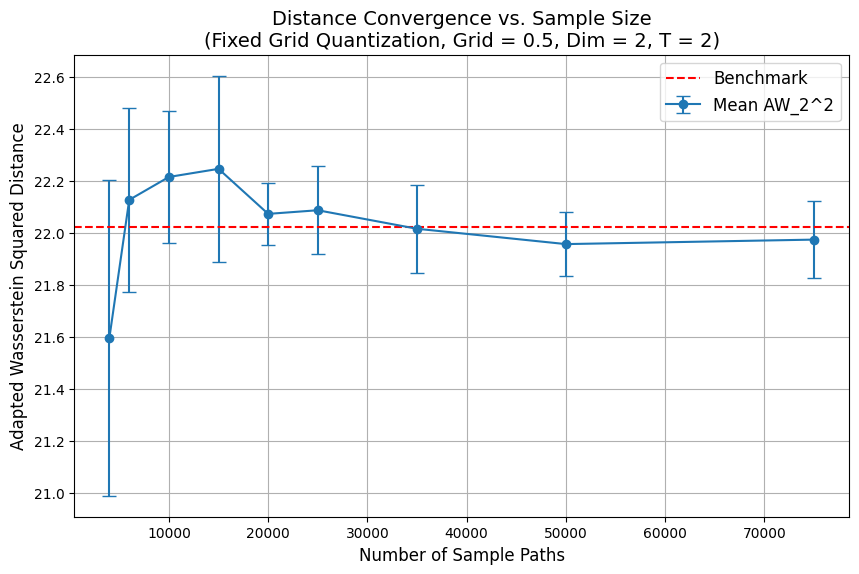

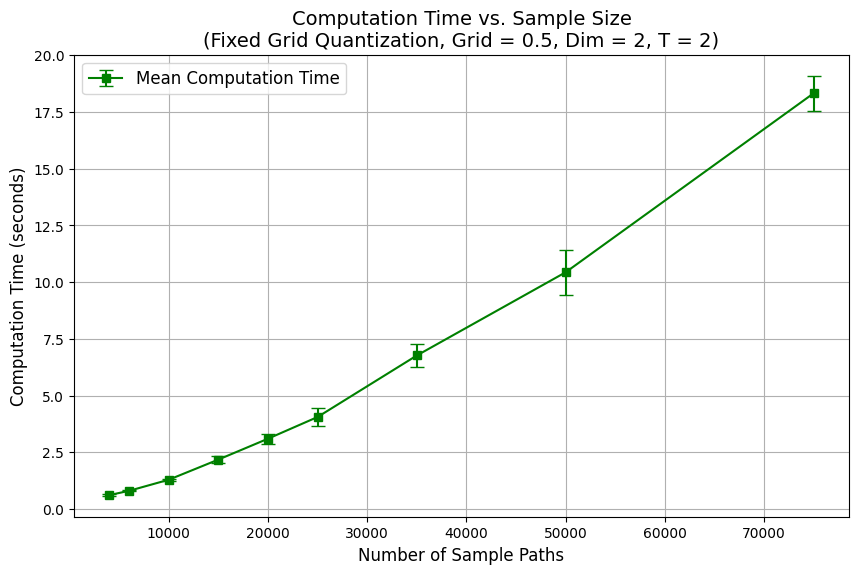

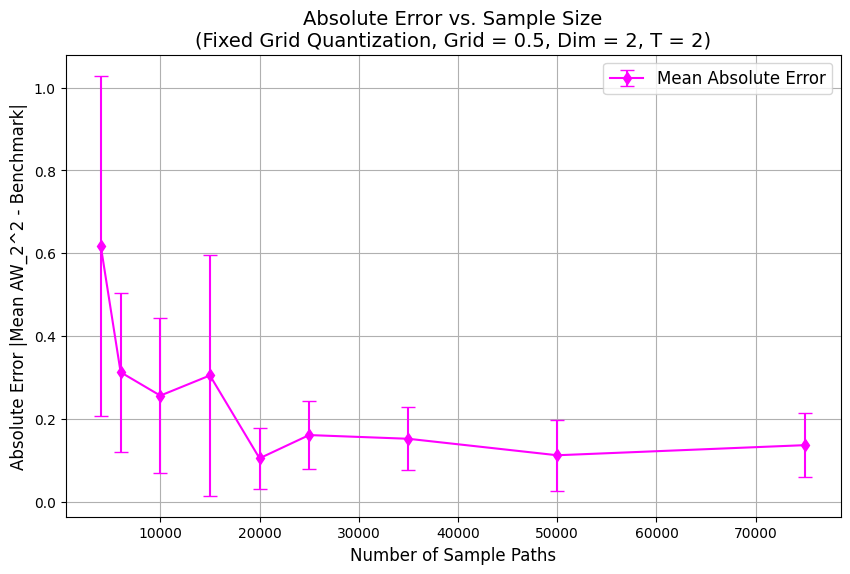

In [4]:
print("\nAggregated Results:")
aggregated = {}
for n_sample in sorted(results.keys()):
    data = results[n_sample]
    dists = data["distances"]
    times = data["times"]
    bench = data["benchmark"]
    mean_dist = np.mean(dists)
    std_dist = np.std(dists)
    mean_time = np.mean(times)
    std_time = np.std(times)
    abs_errors = np.abs(dists - bench)
    mean_abs_err = np.mean(abs_errors)
    std_abs_err = np.std(abs_errors)
    aggregated[n_sample] = {
        "mean_distance": mean_dist,
        "std_distance": std_dist,
        "mean_time": mean_time,
        "std_time": std_time,
        "mean_abs_error": mean_abs_err,
        "std_abs_error": std_abs_err,
        "benchmark": bench
    }
    print(f"Sample Size: {n_sample}")
    print(f"  Mean AW_2^2: {mean_dist:.4f} ± {std_dist:.4f}")
    print(f"  Mean Time: {mean_time:.4f} s ± {std_time:.4f} s")
    print(f"  Mean Absolute Error: {mean_abs_err:.4f} ± {std_abs_err:.4f}")
    print(f"  Benchmark: {bench:.4f}\n")


sample_list = sorted(aggregated.keys())
mean_distances = [aggregated[n]["mean_distance"] for n in sample_list]
std_distances = [aggregated[n]["std_distance"] for n in sample_list]
mean_times = [aggregated[n]["mean_time"] for n in sample_list]
std_times = [aggregated[n]["std_time"] for n in sample_list]
mean_abs_errors = [aggregated[n]["mean_abs_error"] for n in sample_list]
std_abs_errors = [aggregated[n]["std_abs_error"] for n in sample_list]
benchmark = aggregated[sample_list[0]]["benchmark"]  # assuming benchmark is the same across sizes

# Plot 1: Distance Convergence
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_distances, yerr=std_distances, fmt="o-", capsize=5, label="Mean AW_2^2")
plt.axhline(y=benchmark, color="red", linestyle="--", label="Benchmark")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Adapted Wasserstein Squared Distance", fontsize=12)
plt.title("Distance Convergence vs. Sample Size\n(Fixed Grid Quantization, Grid = 0.5, Dim = 2, T = 2)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 2: Computation Time
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_times, yerr=std_times, fmt="s-", capsize=5, color="green", label="Mean Computation Time")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Computation Time (seconds)", fontsize=12)
plt.title("Computation Time vs. Sample Size\n(Fixed Grid Quantization, Grid = 0.5, Dim = 2, T = 2)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 3: Absolute Error
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_abs_errors, yerr=std_abs_errors, fmt="d-", capsize=5, color="magenta", label="Mean Absolute Error")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Absolute Error |Mean AW_2^2 - Benchmark|", fontsize=12)
plt.title("Absolute Error vs. Sample Size\n(Fixed Grid Quantization, Grid = 0.5, Dim = 2, T = 2)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

If one manages to implement an adapted measure using k-means and that is really fast, it would be interesting to compare the results above using the fixed grid with the k-means grid. Based on preliminary computations on smaller examples, we believe k-means should perform slightly better.